In [368]:
# Data Wrangling & Visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")
%matplotlib inline

# Preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Feature Selection
from sklearn.feature_selection import RFE

# Modeling
from sklearn.linear_model import LogisticRegressionCV, LassoCV
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier

# Parameter tuning
from sklearn import grid_search

# Validation
from sklearn.cross_validation import train_test_split, KFold
from sklearn.metrics import confusion_matrix, classification_report

## Predicting Telecom Customer Churn

1. Data Collection & Processing
2. Exploratory Data Analysis
3. Feature Engineering
4. Feature Selection Using Lasso and Logistic Regression + Random Forest
5. Modeling  
    5.1 Initial Results  
    5.2 Tuning (Grid Search)  
6. Validation
7. Churn Measurements  
    7.1 Losses, Expected Losses, high probability churn candidates

## Data Collection & Processing

In [362]:
# Download dataset
# ! wget https://raw.githubusercontent.com/EricChiang/churn/master/data/churn.csv
# ! mkdir data
# ! mv churn.csv ./data/churn.csv

In [260]:
# Creating churn dataframe
churn = pd.read_csv('data/churn.csv')

In [261]:
# Column name cleanup
churn.rename(columns = {'Churn?': 'Churn'}, inplace=True)
churn.rename(columns = {"Int'l Plan":"Intl Plan"}, inplace=True)

In [262]:
churn.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3333 entries, 0 to 3332
Data columns (total 21 columns):
State             3333 non-null object
Account Length    3333 non-null int64
Area Code         3333 non-null int64
Phone             3333 non-null object
Intl Plan         3333 non-null object
VMail Plan        3333 non-null object
VMail Message     3333 non-null int64
Day Mins          3333 non-null float64
Day Calls         3333 non-null int64
Day Charge        3333 non-null float64
Eve Mins          3333 non-null float64
Eve Calls         3333 non-null int64
Eve Charge        3333 non-null float64
Night Mins        3333 non-null float64
Night Calls       3333 non-null int64
Night Charge      3333 non-null float64
Intl Mins         3333 non-null float64
Intl Calls        3333 non-null int64
Intl Charge       3333 non-null float64
CustServ Calls    3333 non-null int64
Churn             3333 non-null object
dtypes: float64(8), int64(8), object(5)
memory usage: 572.9+ KB


In [263]:
churn.head(2)

,State,Account Length,Area Code,Phone,Intl Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,...,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.7,1,False.
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.7,1,False.


In [264]:
# Binarizing all columns at once
churn.replace('no', 0, inplace=True)
churn.replace('yes', 1, inplace=True)
churn.replace('False.', 0, inplace=True)
churn.replace('True.', 1, inplace=True)

In [265]:
X_exploratory = churn.copy()
# Dropping customer contact columns
customer_contact = churn[['Area Code', 'Phone', 'State']]

In [266]:
# Encoding State into numerical representation
state_encoder = LabelEncoder()
churn.State = state_encoder.fit_transform(churn.State)

In [267]:
# Dropping customer contact columns
drop_cols = ['Area Code', 'Phone', 'State']
churn.drop(drop_cols, axis=1, inplace=True)

In [268]:
# Setting up for modeling
y = churn.Churn
X = churn.drop("Churn", axis=1, inplace=True)
X = churn
columns = X.columns

In [269]:
X.shape

(3333, 17)

In [270]:
y.shape

(3333,)

## Exploratory Data Analysis

In [392]:
# Class Imbalance
X_exploratory.groupby('Churn')['Churn'].count()

Churn
0    2850
1     483
Name: Churn, dtype: int64

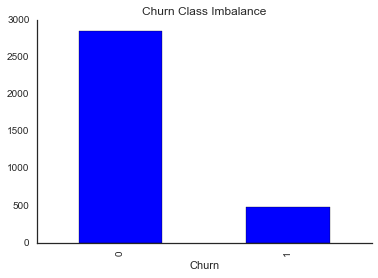

In [403]:
X_exploratory.groupby('Churn')['Churn'].count().plot(kind='bar')
plt.title('Churn Class Imbalance')
sns.despine();

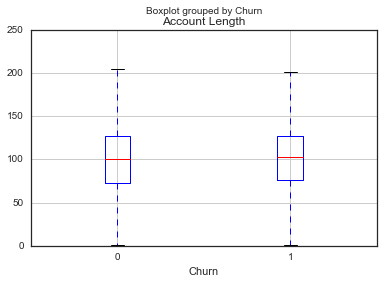

In [369]:
# No extreme churn distribution shift by account length; no outliers
X_exploratory.boxplot(column='Account Length', by='Churn');

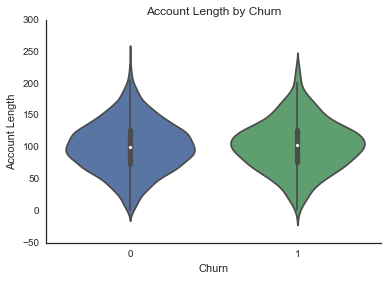

In [408]:
# Normal Distribution for Account Lengths
sns.violinplot(x=X_exploratory.Churn, y=X_exploratory['Account Length'])
plt.title('Account Length by Churn')
sns.despine();

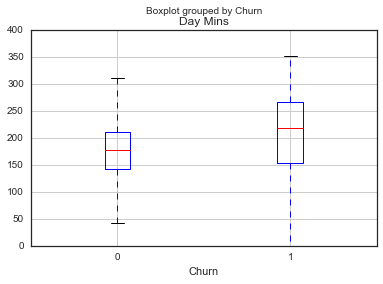

In [371]:
# Day Mins is definitely predictive; No outliers to consider filtering
X_exploratory.boxplot(column="Day Mins", by="Churn");

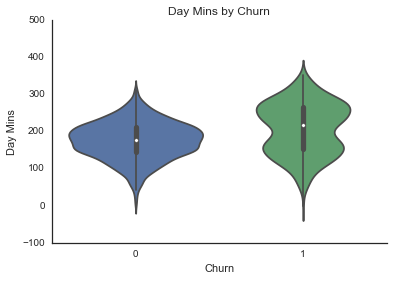

In [409]:
# Interestingly bimodal distribution on churn customers; they either talked a lot or not much
sns.violinplot(x=X_exploratory.Churn, y=X_exploratory['Day Mins'])
plt.title('Day Mins by Churn')
sns.despine();

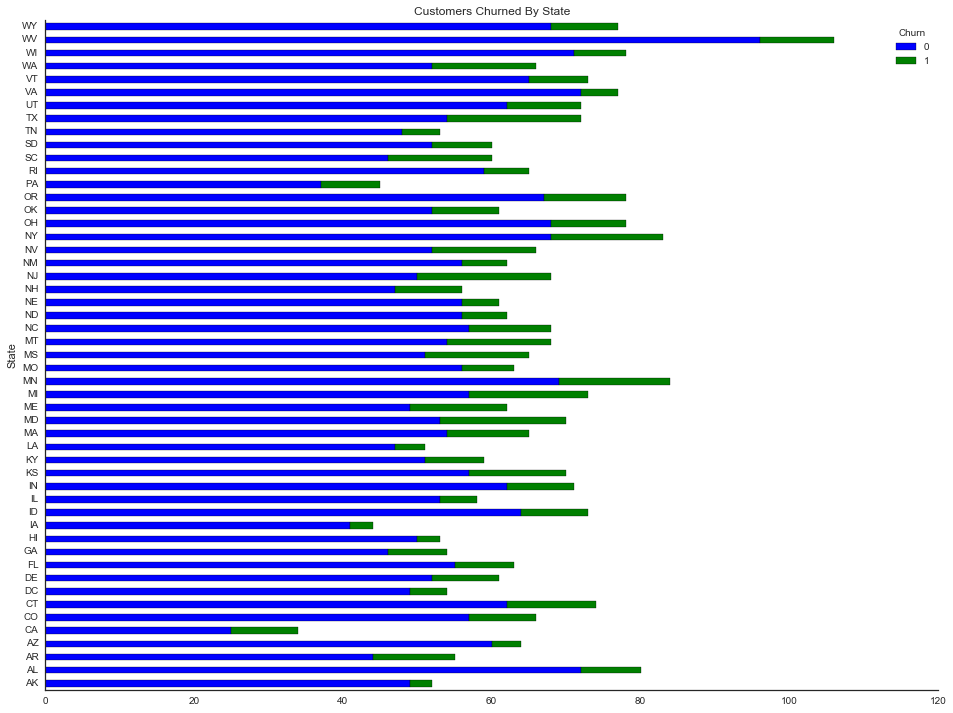

In [370]:
churn2 = X_exploratory.groupby(['State','Churn'])['Churn'].count().unstack()
churn2.plot(kind='barh',stacked=True, figsize=(16,12), title='Customers Churned By State')
sns.despine();

In [415]:
churn_subset1 = X_exploratory[['Account Length', 'Intl Plan', 'VMail Plan', 'CustServ Calls', 'Churn']]

In [412]:
churn_subset2 = X_exploratory[['Day Mins', 'Day Calls', 'Day Charge', 'Eve Mins', 'Eve Calls', \
                       'Eve Charge', 'Night Mins', 'Night Calls', 'Night Charge', 'Intl Mins', \
                      'Intl Calls', 'Intl Charge', 'Churn']]

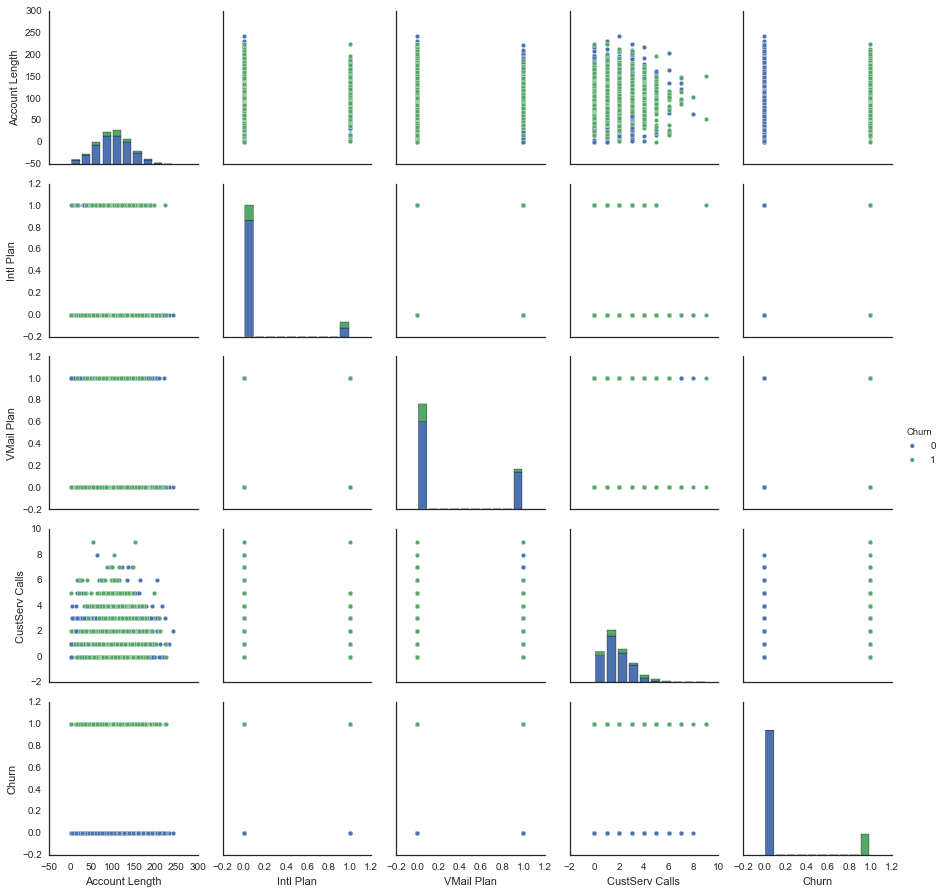

In [416]:
sns.pairplot(churn_subset1, hue='Churn');

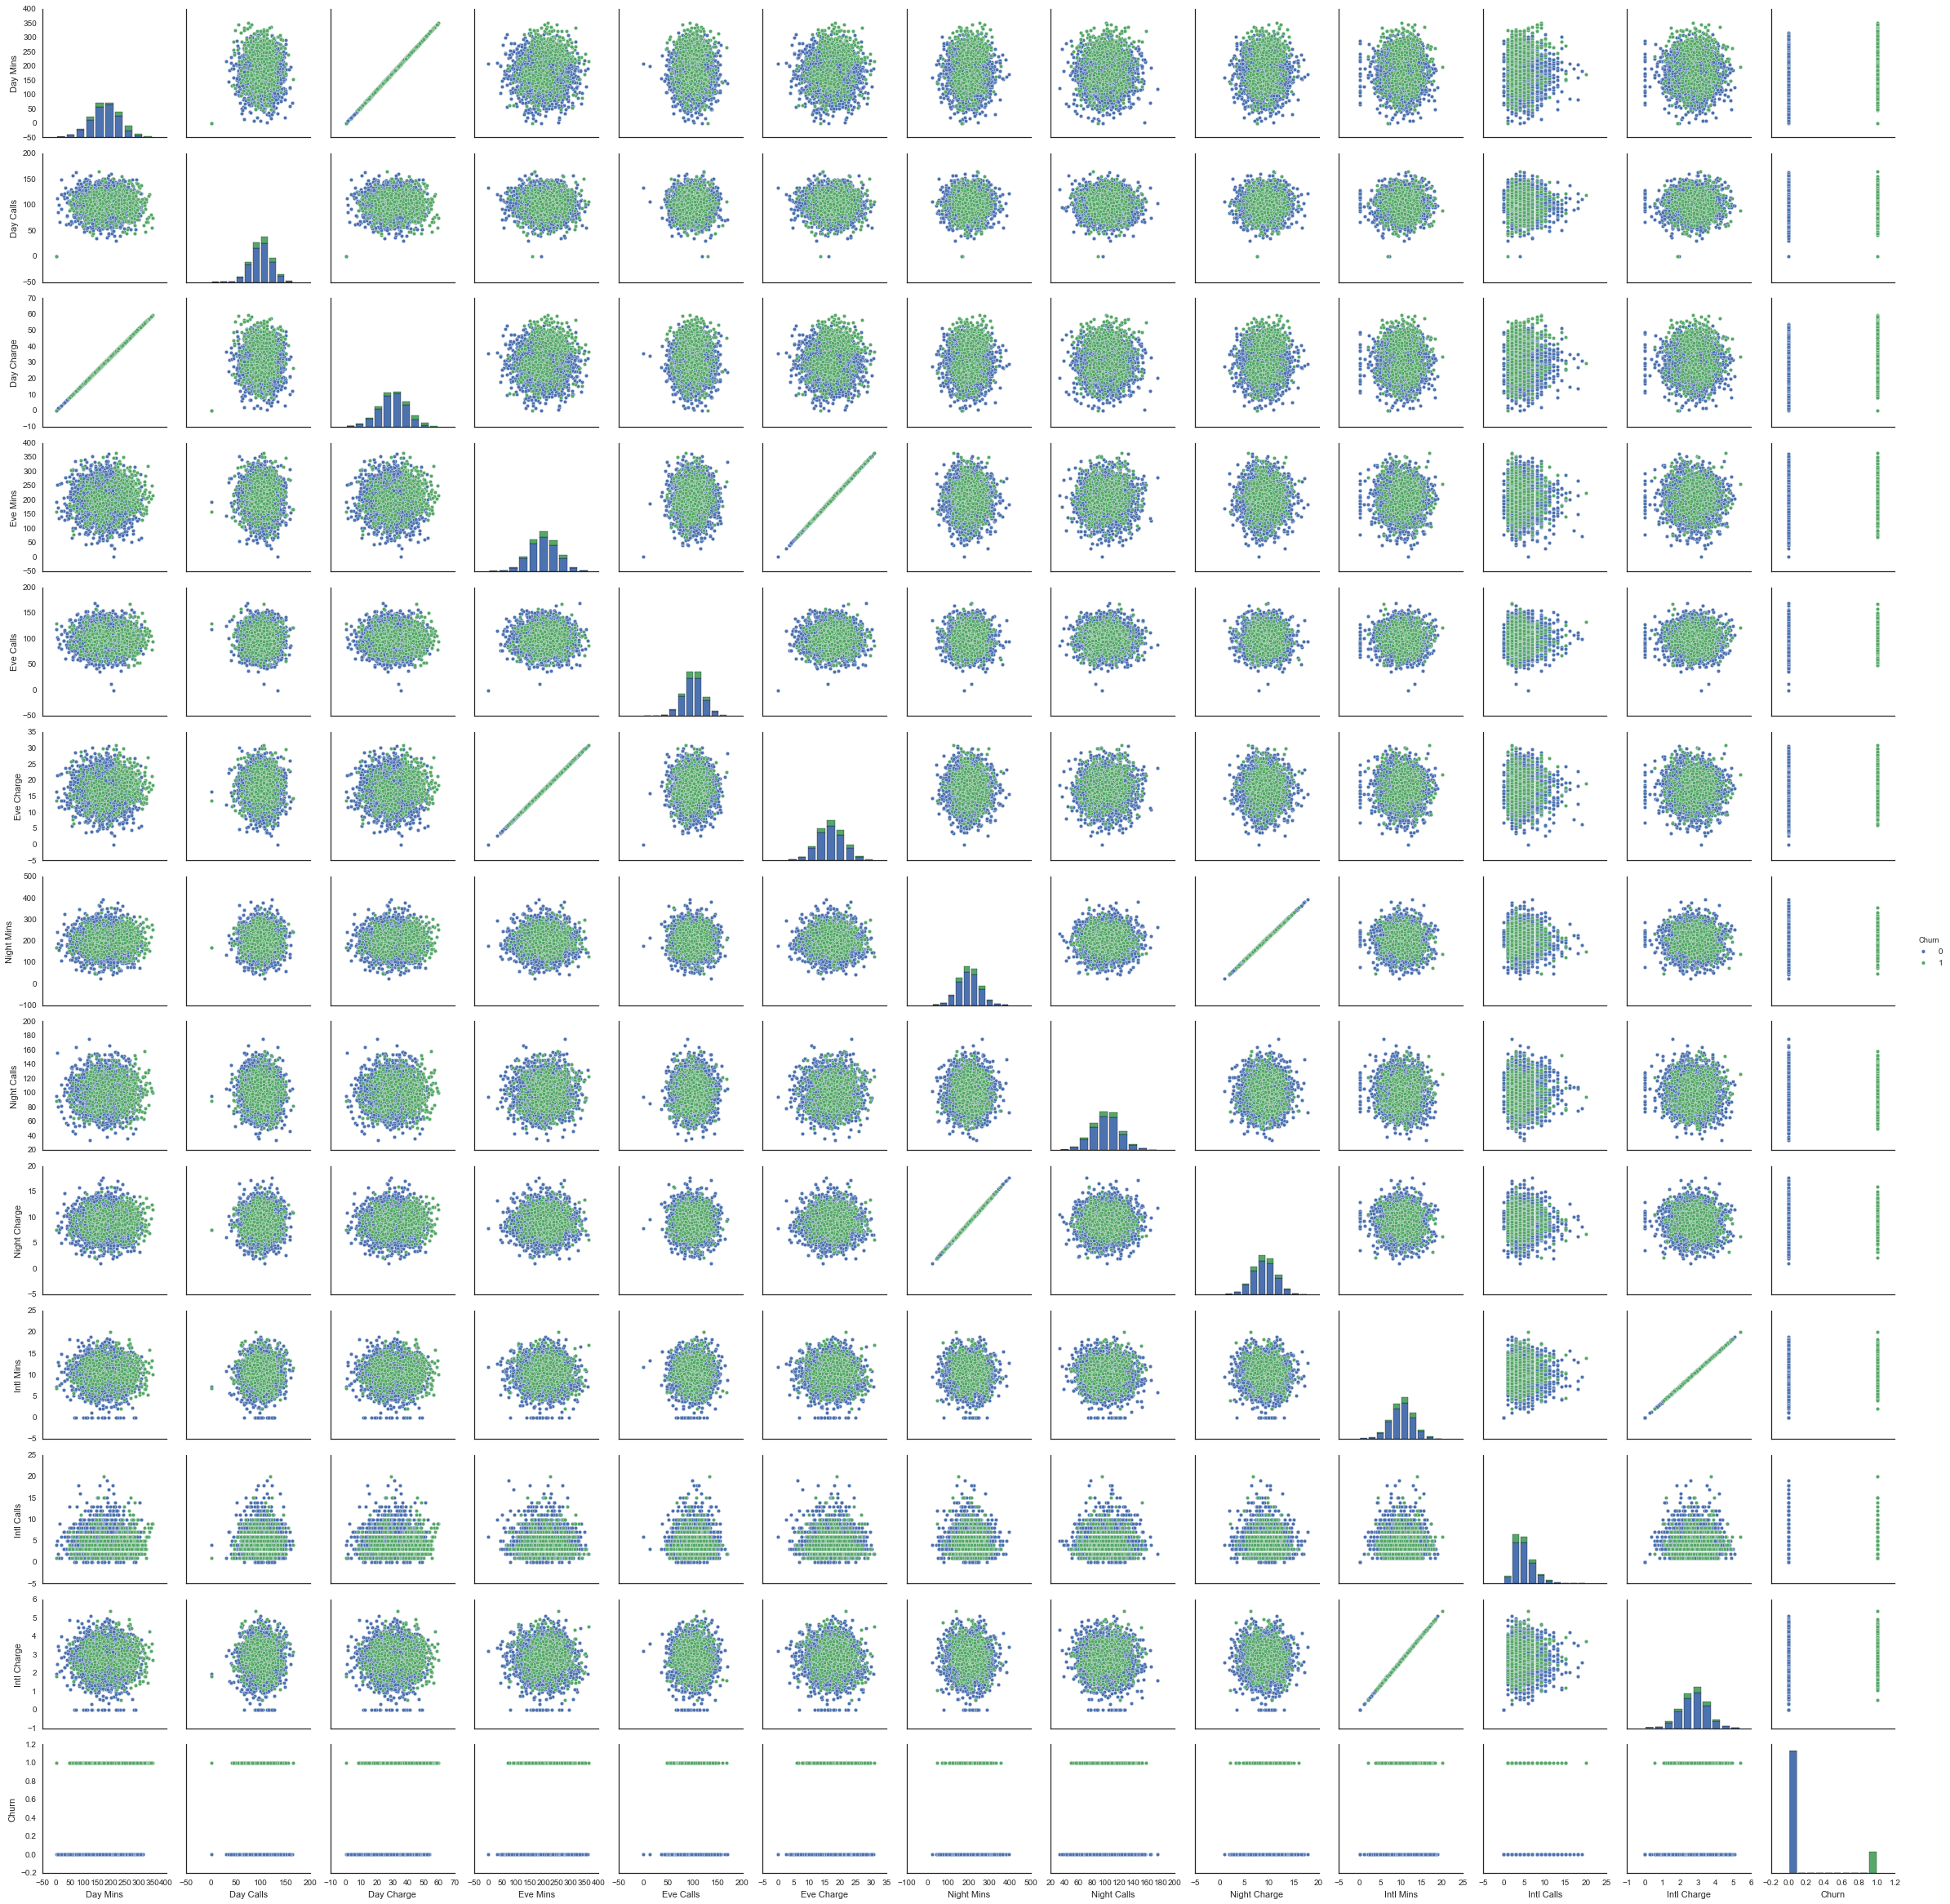

In [413]:
sns.pairplot(churn_subset2, hue='Churn');

**Expected perfect linear relationships between minute and charges**

## Feature Engineering

**Normalizing scale of numerical features; particularly important for linear models and SVMs**

In [169]:
scaler = StandardScaler()

In [170]:
X = scaler.fit_transform(X)

### Feature Selection Using Lasso Regression, Logistic Regression, and Random Forest

### Lasso Regression

In [70]:
# L1 regularization penalizes and removes unpredictive features
lasso = LassoCV()

In [71]:
lasso.fit(X, y)

LassoCV(alphas=None, copy_X=True, cv=None, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=1, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False)

In [72]:
columns

Index([u'State', u'Account Length', u'Intl Plan', u'VMail Plan',
       u'VMail Message', u'Day Mins', u'Day Calls', u'Day Charge', u'Eve Mins',
       u'Eve Calls', u'Eve Charge', u'Night Mins', u'Night Calls',
       u'Night Charge', u'Intl Mins', u'Intl Calls', u'Intl Charge',
       u'CustServ Calls'],
      dtype='object')

In [73]:
zip(enumerate(columns),lasso.coef_)

[((0, 'State'), 0.0016713065378161705),
 ((1, 'Account Length'), 0.0015300975791856764),
 ((2, 'Intl Plan'), 0.08692465290275142),
 ((3, 'VMail Plan'), -0.0331006879882281),
 ((4, 'VMail Message'), -0.0),
 ((5, 'Day Mins'), 0.066472639407858705),
 ((6, 'Day Calls'), 0.0042573533390870026),
 ((7, 'Day Charge'), 0.0),
 ((8, 'Eve Mins'), 0.030295739624854098),
 ((9, 'Eve Calls'), 0.0),
 ((10, 'Eve Charge'), 0.0),
 ((11, 'Night Mins'), 0.010743026078466014),
 ((12, 'Night Calls'), 0.0),
 ((13, 'Night Charge'), 0.0027838803574382499),
 ((14, 'Intl Mins'), 0.003446464871241655),
 ((15, 'Intl Calls'), -0.017294021217728307),
 ((16, 'Intl Charge'), 0.016524068926176059),
 ((17, 'CustServ Calls'), 0.074025380103651214)]

In [35]:
# zip(enumerate(columns),lasso.coef_)

In [34]:
X_LassoSubset = X[:,[0,1,2,4,5,7,10,12,13,14,15,16]]

**Lasso removed some of the features with perfect linearity between each other; creating subset of X for modeling stage**

In [74]:
# Baseline
model_scoring(X, y, LogisticRegressionCV())

Classification Report (10-fold cv): 

              precision    recall  f1-score   support

          0       0.84      0.99      0.91       274
          1       0.82      0.15      0.26        59

avg / total       0.84      0.84      0.80       333



In [75]:
model_scoring(X_LassoSubset, y, LogisticRegressionCV())

Classification Report (10-fold cv): 

              precision    recall  f1-score   support

          0       0.85      0.96      0.90       271
          1       0.63      0.27      0.38        62

avg / total       0.81      0.83      0.81       333



**Performance-wise, Lasso struggles with the binary features and does not identify churn cases very well**

### Logistic Regression

In [77]:
logit = LogisticRegressionCV()

In [78]:
# Using sklearn feature selector
feature_selector = RFE(estimator=logit, step=1).fit(X, y)

In [320]:
# Listing all columns for reference
columns

Index([u'State', u'Account Length', u'Intl Plan', u'VMail Plan',
       u'VMail Message', u'Day Mins', u'Day Calls', u'Day Charge', u'Eve Mins',
       u'Eve Calls', u'Eve Charge', u'Night Mins', u'Night Calls',
       u'Night Charge', u'Intl Mins', u'Intl Calls', u'Intl Charge',
       u'CustServ Calls'],
      dtype='object')

In [79]:
# Columns with a 1 are predictive
zip(feature_selector.ranking_,columns)

[(7, 'State'),
 (6, 'Account Length'),
 (1, 'Intl Plan'),
 (1, 'VMail Plan'),
 (10, 'VMail Message'),
 (1, 'Day Mins'),
 (5, 'Day Calls'),
 (1, 'Day Charge'),
 (1, 'Eve Mins'),
 (8, 'Eve Calls'),
 (1, 'Eve Charge'),
 (4, 'Night Mins'),
 (9, 'Night Calls'),
 (2, 'Night Charge'),
 (3, 'Intl Mins'),
 (1, 'Intl Calls'),
 (1, 'Intl Charge'),
 (1, 'CustServ Calls')]

In [58]:
# zip(feature_selector.ranking_,columns)

In [42]:
X_LogitSubset = X[:,[1,2,4,6,7,14,15,16]]

In [74]:
# Baseline
model_scoring(X, y, LogisticRegressionCV())

Classification Report (10-fold cv): 

              precision    recall  f1-score   support

          0       0.84      0.99      0.91       274
          1       0.82      0.15      0.26        59

avg / total       0.84      0.84      0.80       333



**Modest improvement with smaller subset of features**

In [83]:
model_scoring(X_LogitSubset, y, LogisticRegressionCV())

Classification Report (10-fold cv): 

              precision    recall  f1-score   support

          0       0.88      0.95      0.92       285
          1       0.46      0.23      0.31        48

avg / total       0.82      0.85      0.83       333



**Overall, logistic regression served as an important baseline and feel for important features but it ultimately performed poorly due to non-linear relationships present in data and presence of several binary features**

### Random Forest

In [280]:
def trees_featureImportances(X, y, model):
    """Returns Feature Importances on Tree-based Classifiers along with visualization"""
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
    classifier = model
    classifier.fit(X_train, y_train)
    classifier_report = model_scoring(X, y, model)
    feature_importances = classifier.feature_importances_
    feature_ranks = np.argsort(feature_importances)[::-1]
    rank_std = np.std([tree.feature_importances_ for tree in classifier.estimators_], axis=0)
    
    plt.figure(figsize=(16,8))
    plt.bar(np.arange(X.shape[1]), feature_importances[feature_ranks], yerr= rank_std[feature_ranks], color='r')
    plt.xticks(np.arange(X.shape[1]) + 0.25, columns[feature_ranks], rotation=45)
    plt.title('Features by Predictive Importance')
    plt.ylabel('Relative Feature Importance');
    
    print "{}".format(classifier_report)
    print "Feature Importances: "
    for f in range(X.shape[1]):
        print "Feature {}: {}, Relative Importance {:.3f}, Std: {:.3f}".format(f+1, columns[feature_ranks[f]], feature_importances[feature_ranks[f]], rank_std[feature_ranks[f]])

Classification Report (10-fold cv): 

              precision    recall  f1-score   support

          0       0.96      1.00      0.98       282
          1       1.00      0.75      0.85        51

avg / total       0.96      0.96      0.96       333

None
Feature Importances: 
Feature 1: VMail Message, Relative Importance 0.253, Std: 0.035
Feature 2: Night Mins, Relative Importance 0.130, Std: 0.020
Feature 3: Day Mins, Relative Importance 0.107, Std: 0.025
Feature 4: Intl Plan, Relative Importance 0.090, Std: 0.031
Feature 5: Eve Calls, Relative Importance 0.064, Std: 0.025
Feature 6: Day Calls, Relative Importance 0.058, Std: 0.014
Feature 7: Eve Charge, Relative Importance 0.058, Std: 0.022
Feature 8: Day Charge, Relative Importance 0.057, Std: 0.016
Feature 9: Eve Mins, Relative Importance 0.055, Std: 0.024
Feature 10: Account Length, Relative Importance 0.052, Std: 0.015
Feature 11: State, Relative Importance 0.046, Std: 0.013
Feature 12: VMail Plan, Relative Importance 0.030, 

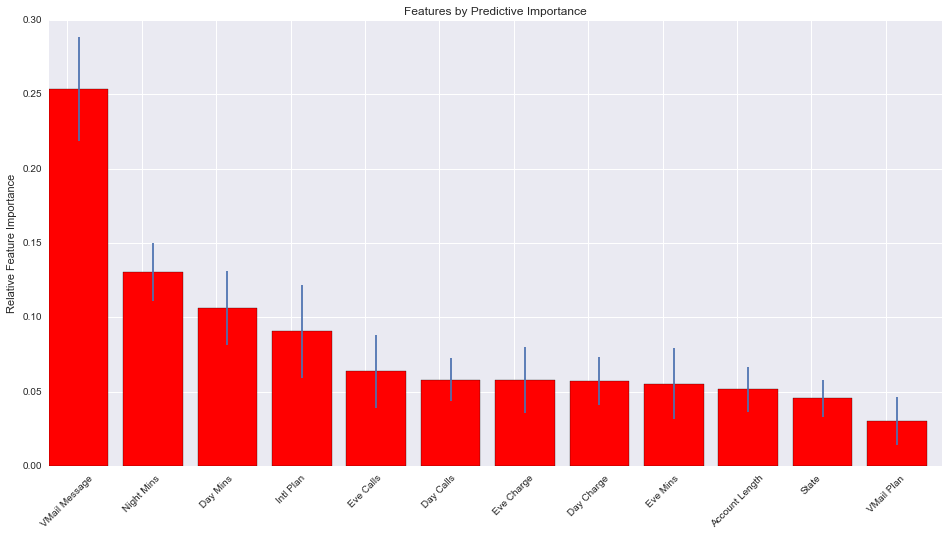

In [327]:
trees_featureImportances(X_LassoSubset, y, RandomForestClassifier(n_estimators=100))

**Note: Dropped state column at this point. 2 out of 3 feature selection methods did not find it important and there is too many factors wrapped up in state (e.g. incomes, coverage infrastructure, etc.) to make it worth keeping.**

## Modeling

In [ ]:
# Thinking Logistic Regression, Random Forest / other tree-based model because of mixed feature types, and one-class
# SVMs due to unbalanced class issue

In [20]:
# Printing columns again for reference
columns

Index([u'Account Length', u'Intl Plan', u'VMail Plan', u'VMail Message',
       u'Day Mins', u'Day Calls', u'Day Charge', u'Eve Mins', u'Eve Calls',
       u'Eve Charge', u'Night Mins', u'Night Calls', u'Night Charge',
       u'Intl Mins', u'Intl Calls', u'Intl Charge', u'CustServ Calls'],
      dtype='object')

In [25]:
MODELS = {'Random Forest': RandomForestClassifier(), \
          'Support Vector Machine': svm.SVC()}

PARAMETERS = {'Random Forest':{'n_estimators': [10,20,50,100]}, \
             'Support Vector Machine': {'kernel':['linear', 'rbf'], 'C':[1,3,5,7]}}


def gridsearch_models(models, parameters, scoring_methods):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.50, random_state=0)
    for name, model in models.items():
        for score in scoring_methods:
            print "Tuning {} model for {} score \n".format(name, score)
            optimal_model = grid_search.GridSearchCV(model, parameters[name], cv=5, scoring='%s_weighted' % score)
            optimal_model.fit(X_train, y_train)
            print "Best parameters are: \n {} \n".format(optimal_model.best_params_)
            print "Grid scores on test set: \n"
            for params, mean_score, scores in optimal_model.grid_scores_:
                print("{:.3f}, std: {:.3f} for {}".format(mean_score, scores.std() * 2, params))
            print "\n Classification Report: \n {} \n".format(classification_report(y_test, optimal_model.predict(X_test)))

In [26]:
gridsearch_models(MODELS, PARAMETERS, ['f1','precision', 'recall'])

Tuning Support Vector Machine model for f1 score 

Best parameters are: 
 {'kernel': 'rbf', 'C': 5} 

Grid scores on test set: 

0.791, std: 0.003 for {'kernel': 'linear', 'C': 1}
0.898, std: 0.017 for {'kernel': 'rbf', 'C': 1}
0.791, std: 0.003 for {'kernel': 'linear', 'C': 3}
0.919, std: 0.021 for {'kernel': 'rbf', 'C': 3}
0.791, std: 0.003 for {'kernel': 'linear', 'C': 5}
0.921, std: 0.021 for {'kernel': 'rbf', 'C': 5}
0.791, std: 0.003 for {'kernel': 'linear', 'C': 7}
0.920, std: 0.017 for {'kernel': 'rbf', 'C': 7}

 Classification Report: 
              precision    recall  f1-score   support

          0       0.94      0.98      0.96      1422
          1       0.83      0.62      0.71       245

avg / total       0.92      0.93      0.92      1667
 

Tuning Support Vector Machine model for precision score 

Best parameters are: 
 {'kernel': 'rbf', 'C': 5} 

Grid scores on test set: 

0.735, std: 0.004 for {'kernel': 'linear', 'C': 1}
0.908, std: 0.025 for {'kernel': 'rbf', 'C':

## Validation

**Conscious choice not to artificially balance classes to control for in-sample class imbalance due to assumption that sample is representative of the population; my focus is more on making a model more heavily weighted toward generalizing out-of-sample**

In [171]:
def model_scoring(X, y, model):
    kf = KFold(len(X), n_folds=10, shuffle=True)
    for train_index, test_index in kf:
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        classifier = model
        classifier.fit(X_train, y_train) 
    y_pred = classifier.predict(X_test)
    print "Classification Report (10-fold cv): \n\n {}".format(classification_report(y_test, y_pred))

**Random Forest Classifier: Performance on X, X_LassoSubset, X_LogitSubset**

In [172]:
model_scoring(X, y, RandomForestClassifier(n_estimators=100))

Classification Report (10-fold cv): 

              precision    recall  f1-score   support

          0       0.98      0.99      0.98       287
          1       0.95      0.85      0.90        46

avg / total       0.97      0.97      0.97       333



In [173]:
model_scoring(X_LassoSubset, y, RandomForestClassifier(n_estimators=100))

Classification Report (10-fold cv): 

              precision    recall  f1-score   support

          0       0.96      1.00      0.98       287
          1       0.97      0.72      0.82        46

avg / total       0.96      0.96      0.96       333



In [174]:
model_scoring(X_LogitSubset, y, RandomForestClassifier(n_estimators=100))

Classification Report (10-fold cv): 

              precision    recall  f1-score   support

          0       0.97      0.99      0.98       281
          1       0.91      0.81      0.86        52

avg / total       0.96      0.96      0.96       333



**SVM: Performance on X, X_LassoSubset, X_LogitSubset**

In [175]:
model_scoring(X, y, svm.SVC(C=5, kernel='rbf'))

Classification Report (10-fold cv): 

              precision    recall  f1-score   support

          0       0.95      0.99      0.97       285
          1       0.89      0.69      0.78        48

avg / total       0.94      0.94      0.94       333



In [176]:
model_scoring(X_LassoSubset, y, svm.SVC(C=5, kernel='rbf'))

Classification Report (10-fold cv): 

              precision    recall  f1-score   support

          0       0.95      0.99      0.97       285
          1       0.94      0.71      0.81        48

avg / total       0.95      0.95      0.95       333



In [177]:
model_scoring(X_LogitSubset, y, svm.SVC(C=5, kernel='rbf'))

Classification Report (10-fold cv): 

              precision    recall  f1-score   support

          0       0.95      0.99      0.97       273
          1       0.92      0.78      0.85        60

avg / total       0.95      0.95      0.95       333



### Modeling Summary:

**I selected the Random Forest Classifier because of its high predictive scores, particularly its recall score (proportion of churn cases correctly identified as having churned). While the subset of features produced by Lasso Regression was competitive, I ultimately opted for the inclusion of all non customer contact related features. Also, because of the model's interpretibility and ability to parallelize. Ultimately, more data is needed to determine the ability of my model to generalize well**

Classification Report (10-fold cv): 

              precision    recall  f1-score   support

          0       0.97      1.00      0.98       281
          1       0.98      0.85      0.91        52

avg / total       0.97      0.97      0.97       333

None
Feature Importances: 
Feature 1: Day Charge, Relative Importance 0.157, Std: 0.078
Feature 2: Day Mins, Relative Importance 0.130, Std: 0.071
Feature 3: CustServ Calls, Relative Importance 0.111, Std: 0.022
Feature 4: Intl Plan, Relative Importance 0.083, Std: 0.031
Feature 5: Eve Mins, Relative Importance 0.067, Std: 0.024
Feature 6: Eve Charge, Relative Importance 0.064, Std: 0.020
Feature 7: Intl Calls, Relative Importance 0.052, Std: 0.025
Feature 8: Intl Mins, Relative Importance 0.042, Std: 0.022
Feature 9: Intl Charge, Relative Importance 0.042, Std: 0.023
Feature 10: Night Charge, Relative Importance 0.039, Std: 0.013
Feature 11: Night Mins, Relative Importance 0.038, Std: 0.013
Feature 12: VMail Message, Relative Importanc

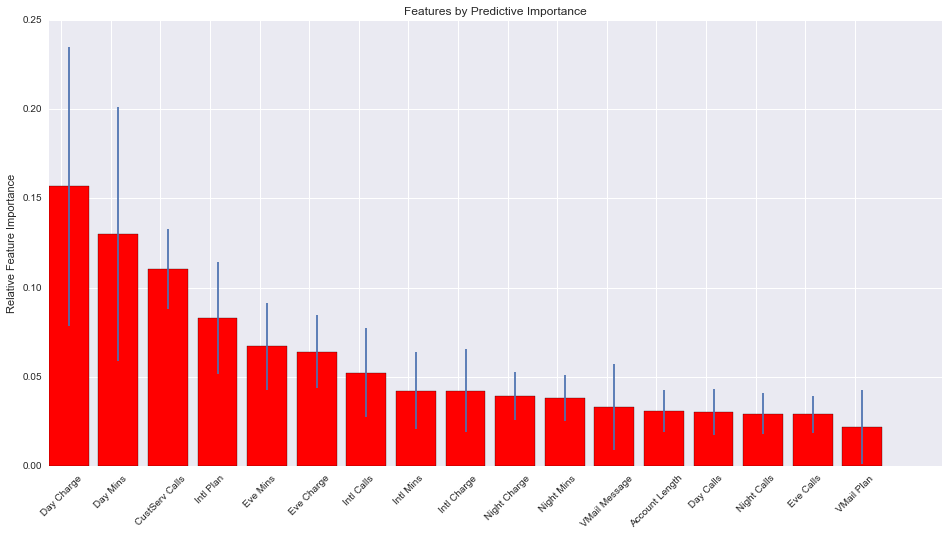

In [249]:
trees_featureImportances(X,y, RandomForestClassifier(n_estimators=100))

In [273]:
rf_cm = confusion_matrix(y_test, rf.predict(X_test))
print rf_cm

[[977   2]
 [  3 152]]


In [354]:
def plot_confusion_matrix(cm, labels):
    """Method to plot confusion matrix"""
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    cax = ax.matshow(cm, cmap=plt.cm.Blues)
    plt.title('Random Forest Confusion Matrix\n')
    plt.tight_layout()
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('True Class')

    for i,j in ((x,y) for x in xrange(2) for y in xrange(2)):
        ax.annotate(str(cm[i][j]), xy=(i,j), color='red')
    
    plt.show()

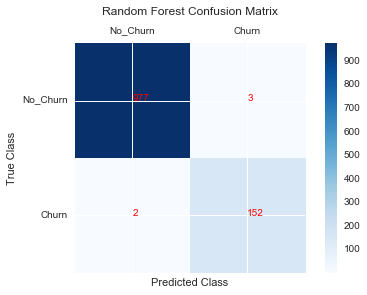

In [355]:
plot_confusion_matrix(rf_cm, ['No_Churn','Churn'])

## Churn Measurements

In [217]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.34, random_state=0)

In [218]:
rf = RandomForestClassifier(n_estimators=100)

In [219]:
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [220]:
model_scoring(X, y, rf)

Classification Report (10-fold cv): 

              precision    recall  f1-score   support

          0       0.97      0.99      0.98       285
          1       0.93      0.83      0.88        48

avg / total       0.97      0.97      0.97       333



In [246]:
# customer_worth = total charges
# sort(expected losses) = customer_worth * churn_probability
customer_LTV = np.zeros((len(y),1))
customer_LTV[:,0] = churn['Day Charge'] + churn['Eve Charge'] + churn['Intl Charge'] + churn['Night Charge']

In [247]:
priorities = pd.DataFrame(data=customer_LTV,columns=['Customer_LTV'])

In [248]:
churn.head(2)

,Account Length,Intl Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls
0,128,0,1,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.7,1
1,107,0,1,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.7,1


In [249]:
# Computing predicted probabilities
pred_probs = rf.predict_proba(X)
pred_probs.shape

(3333, 2)

In [250]:
priorities.head()

,Customer_LTV
0,75.56
1,59.24
2,62.29
3,66.80
4,52.09


In [251]:
# Actual Churn
priorities['Churn_Act'] = y.copy()
# Predicted Churn
priorities["Churn_Pred"] = rf.predict(X)
# Predicted Probability of No Churn
priorities['No_Churn_Prob'] = pred_probs[:,0]
# Predicted Probability of Churn
priorities['Churn_Prob'] = pred_probs[:,1]

In [252]:
priorities.head()

,Customer_LTV,Churn_Act,Churn_Pred,No_Churn_Prob,Churn_Prob
0,75.56,0,0,0.96,0.04
1,59.24,0,0,1.00,0.00
2,62.29,0,0,1.00,0.00
3,66.80,0,0,0.93,0.07
4,52.09,0,0,0.97,0.03


In [253]:
# Expected Loss (Predicted Probability of Churn * Customer_LTV)
priorities['Expected_Loss'] = priorities['Customer_LTV'] * priorities['Churn_Prob']

In [254]:
# Top 20 Customers by Expected Loss
priorities[priorities.Expected_Loss > 0].sort_values(by="Expected_Loss", ascending=False)[:10]

,Customer_LTV,Churn_Act,Churn_Pred,No_Churn_Prob,Churn_Prob,Expected_Loss
985,96.15,1,1,0.01,0.99,95.1885
365,92.20,1,1,0.01,0.99,91.2780
605,90.46,1,1,0.00,1.00,90.4600
3205,89.76,1,1,0.01,0.99,88.8624
1679,88.66,1,1,0.01,0.99,87.7734
289,89.31,1,1,0.02,0.98,87.5238
3132,87.35,1,1,0.00,1.00,87.3500
2696,87.28,1,1,0.00,1.00,87.2800
2824,87.27,1,1,0.00,1.00,87.2700
914,88.13,1,1,0.01,0.99,87.2487


In [255]:
priorities[priorities.Churn_Act == 1].sum()

Customer_LTV     31566.9300
Churn_Act          483.0000
Churn_Pred         475.0000
No_Churn_Prob       77.8800
Churn_Prob         405.1200
Expected_Loss    26515.5518
dtype: float64

### There were 483 customers who churned, representing $31,566.93 in charges

In [256]:
# (False Positives) Customers Predicted to Churn but Haven't... yet
priorities[(priorities.Churn_Act == 0) & (priorities.Churn_Pred == 1)].sort_values(by="Expected_Loss", ascending=False)

,Customer_LTV,Churn_Act,Churn_Pred,No_Churn_Prob,Churn_Prob,Expected_Loss
3140,73.80,0,1,0.38,0.62,45.7560
635,56.88,0,1,0.28,0.72,40.9536
2801,59.47,0,1,0.46,0.54,32.1138


In [257]:
priorities[(priorities.Churn_Act == 0) & (priorities.Churn_Pred == 1)]['Customer_LTV'].sum()

190.14999999999998

In [258]:
priorities[(priorities.Churn_Act == 0) & (priorities.Churn_Pred == 1)]['Expected_Loss'].sum()

118.8234

In [271]:
# Contact information for churn candidates
customer_contact.iloc[[635,2801,3140]]

,Area Code,Phone,State
635,510,328-8147,CO
2801,408,355-2872,HI
3140,408,382-2026,IN


In [272]:
# Churn candidate behavior information for use on call
churn.iloc[[635,2801,3140]]

,Account Length,Intl Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls
635,120,0,1,27,153.5,84,26.10,194.0,73,16.49,256.5,94,11.54,10.2,7,2.75,5
2801,3,0,0,0,139.0,99,23.63,250.7,108,21.31,286.2,87,12.88,6.1,3,1.65,4
3140,104,0,0,0,280.4,127,47.67,179.4,79,15.25,150.6,77,6.78,15.2,6,4.10,5


### There are 3 high probability churn customers, worth 190.15 dollars, that have not churned yet. These customers can be targeted through customer contact, promotions, and marketing to dissuade them from churning and to avoid expected losses of 118.82 dollars

## Future Directions

1. Write definitive Python package for Churn Modeling; open-source to Github and prepare for flood of job offers

## References

[Yhat Blog](http://blog.yhat.com/posts/predicting-customer-churn-with-sklearn.html)  
[Scikit-learn Docs](http://scikit-learn.org/stable/)  
[Seaborn Docs](https://stanford.edu/~mwaskom/software/seaborn/)